# Machine learning applied to 0D reactors

In this notebook, we will train neural networks to replace the CVODE solver of CANTERA. We will use the databases generated in the *0D_database_generation.ipynb* notebook.

## Imports and options

In [347]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [348]:
import os
import json
import joblib
import numpy as np
import pandas as pd

import cantera as ct

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

from chem_ai.cantera_runs import compute_nn_cantera_0D_homo
from chem_ai.utils import get_molar_mass_atomic_matrix
from chem_ai.utils import StandardScaler

We set the default pytorch precision to double. It slows down a little bit the training but it is the usual standard for CFD reacting flows applications.

In [349]:
torch.set_default_dtype(torch.float64)

We identify the device (CPU or GPU) available on the machine. This will be used by pytorch to identify the device on which to train and use the model:

In [350]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


## Preliminary

### Loading the required data

We define the folder including the desired database:

In [351]:
folder = "./case_0D_highT" 

We load the parameters stored in the json file of the dabatase folder:

In [352]:
with open(os.path.join(folder, "dtb_params.json"), "r") as file:
    dtb_params = json.load(file)

fuel = dtb_params["fuel"]
mech_file = dtb_params["mech_file"]
log_transform = dtb_params["log_transform"]
threshold = dtb_params["threshold"]
p = dtb_params["p"]
dt = dtb_params["dt"]

We load the scalers:

In [353]:
Xscaler = joblib.load(os.path.join(folder, "processed_database", "Xscaler.pkl"))
Yscaler = joblib.load(os.path.join(folder, "processed_database", "Yscaler.pkl"))

We load the training and validation databases:

In [354]:
X_train = pd.read_csv(os.path.join(folder, "processed_database","X_train.csv"))
X_val = pd.read_csv(os.path.join(folder, "processed_database","X_val.csv"))
Y_train = pd.read_csv(os.path.join(folder, "processed_database","Y_train.csv"))
Y_val = pd.read_csv(os.path.join(folder, "processed_database","Y_val.csv"))

Xcols = X_train.columns
Ycols = Y_train.columns

Number of input and output dimensions:

In [355]:
n_in = X_train.shape[1]
n_out = Y_train.shape[1]

### Elements conservation matrix

In combustion, elements (usually C, H, O, N) are preserved when a mixture undergoes chemical reactions, as there are no nuclear reactions. Therefore, the initial mass of elements of a mixture is conserved at the next time step and so on. For a 0D reactors (no mixing), elements mass fractions are constant for a given simulation.

For a given element $j \in {C, H, O, N}$, the mass fraction of this elements can be expressed as:

$$
Y_e^j = \sum_{k=1}^{N_S} \frac{M_j}{M_k} n_k^j Y_k
$$

where $M_j$ and $M_k$ are the molar masses of element $j$ and species $k$ respectively. $n_k^j$ is the number of atoms $j$ in species $k$. This equation can also be written in matrix form:

$$
Y_e = \mathcal{A} Y
$$

where $Y_e \in \mathbb{R}^4$ is the vector of elements mass fractions and $Y \in \mathbb{R}^{N_S}$ the vector of species mass fractions. The matrix $\mathcal{A} \in \mathbb{R}^{4 \times N_S}$ is defined be the following coefficients:

$$
\mathcal{A}_{jk} = \frac{M_j}{M_k} n_k^j
$$

The matrix $\mathcal{A}$ can be computed using the function *get_molar_mass_atomic_matrix* given in *utils.py*:


In [356]:
gas = ct.Solution(mech_file)
A_element = get_molar_mass_atomic_matrix(gas.species_names, fuel, True)
print(A_element)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         1.         0.         0.         0.05926971 0.11190674
  0.         0.0305399  0.05926971]
 [0.         0.         1.         1.         0.94073029 0.88809326
  0.         0.9694601  0.94073029]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]]


This matrix will be helpful to analyze the conservation of elements in the training loop and at inference.

## Model definition and training

The data loaded (scalers, training/validation sets, etc...) are in numpy format. In order to use them in a Pytorch training loop, we need to convert them to *torch* tensors. Those tensors are very similar to numpy arrays, with similar functions.

We first transform training and validation datasets:

In [357]:
X_train = torch.tensor(X_train.values, dtype=torch.float64)
Y_train = torch.tensor(Y_train.values, dtype=torch.float64)
X_val = torch.tensor(X_val.values, dtype=torch.float64)
Y_val = torch.tensor(Y_val.values, dtype=torch.float64)

In order to deal with the scaler, we decide to extract the mean and standard deviation and write the formula directly when necessary. These quantities are here converted to torch tensors:

In [358]:
Xscaler_mean = torch.from_numpy(Xscaler.mean.values)
Xscaler_std = torch.from_numpy(Xscaler.std.values)

Yscaler_mean = torch.from_numpy(Yscaler.mean.values)
Yscaler_std = torch.from_numpy(Yscaler.std.values)

The conservation matrix $A$ also needs to be converted as it will be used during the training loop:

In [359]:
A_element = torch.tensor(A_element, dtype=torch.float64)

Another aspect is that the data needs to be on the correct device, as pytorch will look for the data on it. As CPU and GPU memory is not shared, we will have to manually move the data to the GPU if necessary. We do it here for training/validation data, scalers and conservation matrix:

In [360]:
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

Xscaler_mean = Xscaler_mean.to(device)
Xscaler_std = Xscaler_std.to(device)

Yscaler_mean = Yscaler_mean.to(device)
Yscaler_std = Yscaler_std.to(device)

A_element = A_element.to(device)

We now can generate the model. In this work, we will consider a simple Multi Layer Perceptron (MLP). We generate the model using Pytorch:

In [361]:
class ChemNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(n_in, 60)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(60, n_out)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x

The model is then instantiated and transferred to the GPU if present:

In [362]:
model = ChemNN()
print(model)

#Put model on GPU
model = model.to(device)

ChemNN(
  (hidden1): Linear(in_features=10, out_features=60, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=60, out_features=60, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=60, out_features=9, bias=True)
)


We now define hyperparameters of the training loop. The following choices need to be made:

+ **n_epochs**: number of passes of entire training dataset through the algorithm.
+ **batch_size**: size of the chunks passed to the algorithm at each parameters update.
+ **loss_fn**: loss function. In this we choose the Mean Square Loss (MSE), which is adapted to the regression problem. Assuming that the output of the ANN is $Y_k^n$ (preprocessed mass fractions) and the true value is $Y_k^{n,*}$, the loss reads:

$$ 
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{N_S} \sum_{k=1}^{N_S} \left( Y_{k,i}^n - Y_{k,i}^{n,*} \right)^2
$$

where $N$ is the number of data points.

+ **optimizer**: optimization method. We use here the standard Adam method with initial learning rate $lr$.

In [363]:
n_epochs = 300
batch_size = 256

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We perform now the main model training loop. In Pytorch the training loop needs to be written but offers flexibility in the way we can compute training monitoring quantities. In this loop, we decide to monitor conservation metrics, i.e. the sum of species mass fractions and the elements mass fractions variation.

*Exercice 1:* Complete the training loop by computing monitoring metrics. Note that these metrics are computed every 10 epochs in order to limit the computational overhead.

1. Compute the validation loss.

2. From the conservation of mass we have $\sum_{k=1}^{N_S} Y_k = 1$. Compute the mean, min and max of $\sum_{k=1}^{N_S} Y_k$ over the entire validation dataset. 

3. Let us note $Y^{in}$ the mass fraction of species at the input of the ANN and $Y^{out}$ at the output (same for elemental mass fractions which are written $Y_e^{in}$ and $Y_e^{out}$). Elements conservation imposes $Y_e^{in}=Y_e^{out}$ which means $\mathcal{A}Y^{in}=\mathcal{A}Y^{out}$. We will consider here the quantity $\delta Y_e = \left( \mathcal{A}Y^{out} - \mathcal{A}Y^{in} \right) / \mathcal{A}Y^{in} \in \mathbb{R}^4$. Compute the mean, min and max of this quantity over the entire validation dataset.

We give the following hints:

+ Do not forget that input of output data of the ANN is preprocessed. For the scaling, you can use directly the mean and std values and the formula, as these vectors have been put to the GPU to that purpose.

+ Metric arrays are defined as numpy arrays on CPU to be later plotted on matplotlib. In order to transfer a GPU torch tensor *tensor_torch* to a CPU numpy array you can use: *tensor_torch.detach().cpu().numpy()*.

+ Matrix multiplication in pytorch can be done using the *torch.matmul* function and transpose by using *torch.transpose*.

In [364]:
def main_training_loop(X_train, X_val, Y_train, Y_val, loss_fn, optimizer, n_epochs, model, log_transform, need_ini_vals):

    # Array to store the loss and validation loss
    loss_list = np.empty(n_epochs)
    val_loss_list = np.empty(n_epochs//10)

    # Array to store sum of mass fractions: mean, min and max
    stats_sum_yk = np.empty((n_epochs//10,3))

    # Array to store elements conservation: mean, min and max
    stats_A_elements = np.empty((n_epochs//10,4,3))

    epochs = np.arange(n_epochs)
    epochs_small = epochs[::10]

    for epoch in range(n_epochs):

        # Training parameters
        for i in range(0, len(X_train), batch_size):

            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = Y_train[i:i+batch_size]
            if need_ini_vals: #used for soft elements constraint later
                loss = loss_fn(y_pred, ybatch, Xbatch[:,1:])
            else:
                loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list[epoch] = loss

        # Computing validation loss and mass conservation metric (only every 10 epochs as it is expensive)
        if epoch%10==0:
            model.eval()  # evaluation mode
            with torch.no_grad():

                # VALIDATION LOSS
                y_val_pred = model(X_val)
                if need_ini_vals:
                    val_loss = loss_fn(y_val_pred, Y_val, X_val[:,1:])
                else:
                    val_loss = loss_fn(y_val_pred, Y_val)

                # SUM OF MASS FRACTION
                #Inverse scale done by hand to stay with Torch arrays
                yk = Yscaler_mean + (Yscaler_std + 1e-7)*y_val_pred
                if log_transform:
                    yk = torch.exp(yk)
                sum_yk = yk.sum(axis=1)
                sum_yk = sum_yk.detach().cpu().numpy()
                stats_sum_yk[epoch//10,0] = sum_yk.mean() 
                stats_sum_yk[epoch//10,1] = sum_yk.min()
                stats_sum_yk[epoch//10,2] = sum_yk.max()

                # ELEMENTS CONSERVATION
                yval_in = Xscaler_mean[1:] + (Xscaler_std[1:] + 1e-7)*X_val[:,1:]
                if log_transform:
                    yval_in = torch.exp(yval_in)
                ye_in = torch.matmul(A_element, torch.transpose(yval_in, 0, 1))
                ye_out = torch.matmul(A_element, torch.transpose(yk, 0, 1))
                delta_ye = (ye_out - ye_in)/(ye_in+1e-10)
                delta_ye = delta_ye.detach().cpu().numpy()
                stats_A_elements[epoch//10, :, 0] = delta_ye.mean(axis=1)
                stats_A_elements[epoch//10, :, 1] = delta_ye.min(axis=1)
                stats_A_elements[epoch//10, :, 2] = delta_ye.max(axis=1)

            model.train()   # Back to training mode
            val_loss_list[epoch//10] = val_loss

        print(f"Finished epoch {epoch}")
        print(f"    >> Loss: {loss}")
        if epoch%10==0:
            print(f"    >> Validation loss: {val_loss}")

    return epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements

In [365]:
epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements = main_training_loop(X_train, X_val, Y_train, Y_val, loss_fn, optimizer, n_epochs, model, log_transform, False)

Finished epoch 0
    >> Loss: 0.007200899974560332
    >> Validation loss: 0.09437637985852795
Finished epoch 1
    >> Loss: 0.0023777384595056487
Finished epoch 2
    >> Loss: 0.0020491957069766658
Finished epoch 3
    >> Loss: 0.0016024982968950367
Finished epoch 4
    >> Loss: 0.00157799133786698
Finished epoch 5
    >> Loss: 0.001058692402134155
Finished epoch 6
    >> Loss: 0.0005545795688423678
Finished epoch 7
    >> Loss: 0.000404080595925145
Finished epoch 8
    >> Loss: 0.00041702183987925344
Finished epoch 9
    >> Loss: 0.0004263969820268434
Finished epoch 10
    >> Loss: 0.0003516415850201528
    >> Validation loss: 0.005448609332093052
Finished epoch 11
    >> Loss: 0.0002839235283304963
Finished epoch 12
    >> Loss: 0.00023759001988904338
Finished epoch 13
    >> Loss: 0.00022950392403054307


Finished epoch 14
    >> Loss: 0.0002554779488054651
Finished epoch 15
    >> Loss: 0.0002493506347317209
Finished epoch 16
    >> Loss: 0.0002353427581876181
Finished epoch 17
    >> Loss: 0.000235747640979951
Finished epoch 18
    >> Loss: 0.0002291012074573664
Finished epoch 19
    >> Loss: 0.0002220177532276232
Finished epoch 20
    >> Loss: 0.00021080258281768184
    >> Validation loss: 0.0029645810943988893
Finished epoch 21
    >> Loss: 0.00020825519602009815
Finished epoch 22
    >> Loss: 0.00021328549766611005
Finished epoch 23
    >> Loss: 0.0002170122356916967
Finished epoch 24
    >> Loss: 0.00022088694741213716
Finished epoch 25
    >> Loss: 0.0002109496340894298
Finished epoch 26
    >> Loss: 0.00018881914378763404
Finished epoch 27
    >> Loss: 0.00017449699765282594
Finished epoch 28
    >> Loss: 0.00016568208863701597
Finished epoch 29
    >> Loss: 0.00015968977155638854
Finished epoch 30
    >> Loss: 0.00015240415839747504
    >> Validation loss: 0.00216772617378142
F

We can define a function to analyze the training. We plot:

+ The training and validation losses

+ The evolution of $\sum_{k=1}^{N_S} Y_k$ (mean, min and max).

+ The elements conservation by plotting $100\times\delta Y_e$ for each element (C, H, O and N). The factor $100$ enables to get an error in \%.

In [366]:
def plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements):

    # LOSSES
    fig, ax = plt.subplots()

    ax.plot(epochs, loss_list, color="k", label="Training")
    ax.plot(epochs_small, val_loss_list, color="r", label = "Validation")

    ax.set_yscale('log')

    ax.legend()

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    # MASS CONSERVATION
    fig, ax = plt.subplots()

    ax.plot(epochs_small, stats_sum_yk[:,0], color="k")
    ax.plot(epochs_small, stats_sum_yk[:,1], color="k", ls="--")
    ax.plot(epochs_small, stats_sum_yk[:,2], color="k", ls="--")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(r"$\sum_k \ Y_k$")

    # ELEMENTS CONSERVATION
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

    # C
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,0], color="k")
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,1], color="k", ls="--")
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,2], color="k", ls="--")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel(r"$\Delta Y_C$ $(\%$)")

    # H
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,0], color="k")
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,1], color="k", ls="--")
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,2], color="k", ls="--")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r"$\Delta Y_H$ $(\%)$")

    # O
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,0], color="k")
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,1], color="k", ls="--")
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,2], color="k", ls="--")

    ax3.set_xlabel("Epoch")
    ax3.set_ylabel(r"$\Delta Y_O$ $(\%)$")

    # N
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,0], color="k")
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,1], color="k", ls="--")
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,2], color="k", ls="--")

    ax4.set_xlabel("Epoch")
    ax4.set_ylabel(r"$\Delta Y_N$ $(\%)$")

    fig.tight_layout()

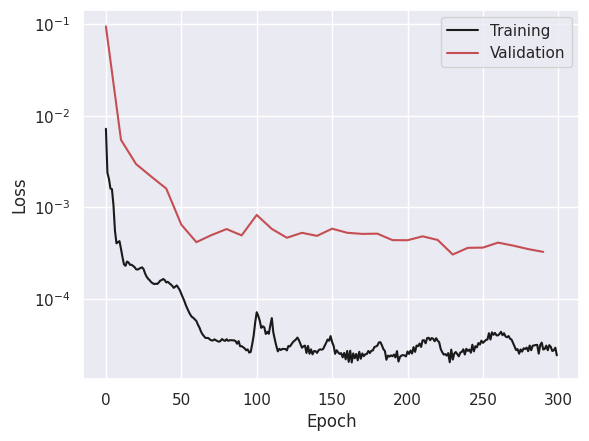

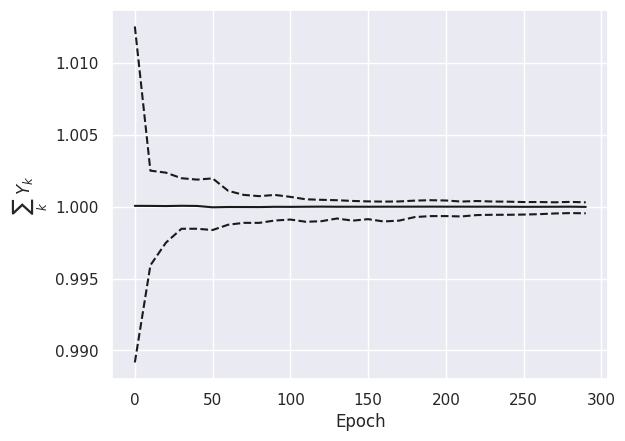

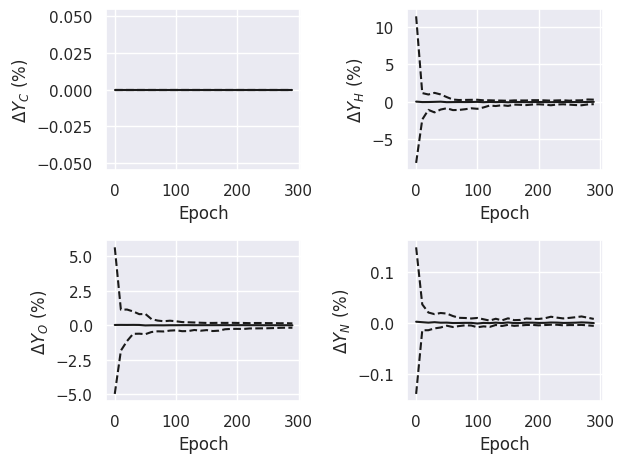

In [367]:
plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements)

We save the Pytorch model in the case folder for later use:

In [368]:
torch.save(model.state_dict(), os.path.join(folder,"pytorch_mlp.pt"))

## ANN model test

Now that we have generated the model we would like to test it on unseen data. For this, we will use the test initial conditions which were stored during data generation. The methodology is as follows:

1. We get the test conditions and simulate CANTERA flames with (i) the CVODE solver and (ii) the generated ANN.
2. We define appropriate metric and assess the accuracy of the ANN.

### Computing simulations with CANTERA and NN

We first load the test initial conditions:

In [369]:
df_sim_test = pd.read_csv(os.path.join(folder, "sim_test.csv"))

n_sim = df_sim_test.shape[0]
print(f"There are {n_sim} test simulations")

There are 64 test simulations


We now want to compute 0D reactors for each conditions in *df_sim_test*. We use here the function *compute_nn_cantera_0D_homo* which is given. It takes as input initial conditions $T_0, \phi$, the ANN model (with associated scalers), the time step (used for the ANN) and the database parameters. It outputs two dataframes containing the exact simulation and the ANN simulation. These results are concatenated in a list.

In [372]:
list_test_results = []

fails = 0
for i, row in df_sim_test.iterrows():

    phi_ini = row['Phi']
    temperature_ini = row['T0']

    print(f"Performing test computation for phi={phi_ini}; T0={temperature_ini}")

    df_exact, df_nn, fail = compute_nn_cantera_0D_homo(device, model, Xscaler, Yscaler, phi_ini, temperature_ini, dt, dtb_params)

    fails += fail

    list_test_results.append((df_exact, df_nn))


print(f"Total number of simulations which crashed: {fails}")

Performing test computation for phi=0.9649956307053712; T0=2138.9999746290405
Performing test computation for phi=0.9123913707200598; T0=2104.8242277533845
Performing test computation for phi=0.8016741785198769; T0=2199.7598044039
Performing test computation for phi=0.8781465862115102; T0=2174.130704859545
Performing test computation for phi=0.8347614315702426; T0=2155.4677342724854
Performing test computation for phi=0.9020456831785444; T0=2164.7392920169123
Performing test computation for phi=0.9453146058370938; T0=2189.981947068785
Performing test computation for phi=0.8853030732536692; T0=2194.4150390009486
Performing test computation for phi=0.8086176607093873; T0=2183.887143896546
Performing test computation for phi=0.9409040388399702; T0=2143.2699658231427
Performing test computation for phi=0.8481990503811442; T0=2128.486025435516
Performing test computation for phi=0.943302580820092; T0=2149.207776503536
Performing test computation for phi=0.9721708133458212; T0=2178.137564845

Here are what dataframes look like for a given simulation:

In [ ]:
i_sim = 1
list_test_results[i_sim][0].head()   # Exact

In [ ]:
list_test_results[i_sim][1].head()   # ANN

We can visualize the results for a given simulation *i_sim*. We can look at temperature and species mass fractions for instance. We can also analyze conservation metrics. If we learned in logarithmic space, it is interesting also to plot in log.

In [ ]:
def plot_results_sim(i_sim, list_test_results, spec_to_plot):

    df_exact = list_test_results[i_sim][0]
    df_nn = list_test_results[i_sim][1]

    # Temperature 
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], df_exact['Temperature'], color='k')
    ax.plot(df_nn['Time'], df_nn['Temperature'], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("T [K]")

    # Species (normal)
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], df_exact[spec_to_plot], color='k')
    ax.plot(df_nn['Time'], df_nn[spec_to_plot], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel(f"{spec_to_plot} [-]")

    # Species (log)
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], np.log(df_exact[spec_to_plot]), color='k')
    ax.plot(df_nn['Time'], np.log(df_nn[spec_to_plot]), color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel(f"{spec_to_plot} [-]")

    # Sum of Yk
    fig, ax = plt.subplots()
    ax.plot(df_nn['Time'], df_nn['SumYk'], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("$\sum Y_k$ [-]")

    # Elements
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    ax1.plot(df_nn['Time'], df_nn['Y_C'], color='b')
    ax2.plot(df_nn['Time'], df_nn['Y_H'], color='b')
    ax3.plot(df_nn['Time'], df_nn['Y_O'], color='b')
    ax4.plot(df_nn['Time'], df_nn['Y_N'], color='b')
    ax1.set_ylabel("$Y_C$")
    ax2.set_ylabel("$Y_H$")
    ax3.set_ylabel("$Y_O$")
    ax4.set_ylabel("$Y_N$")
    ax3.set_xlabel("Time [s]")
    ax4.set_xlabel("Time [s]")
    fig.tight_layout()

In [ ]:
i_sim = 40
spec_to_plot = "H2O2"
plot_results_sim(i_sim, list_test_results, spec_to_plot)

For the ANN run can also check the conservation of mass and elements:

### Analyzing error statistics

We need a metric to assess the accuracy of the ANN over the entire test simulations. To do that, we will define normalized fitness functions for each simulation, and average the values over the simulation. As previously, we note $Y_k^n$ the processed mass fractions (including potential log and scaling) from the ANN, and $Y_k^{n,*}$ the exact values. The error on species mass fractions is then for given initial conditions:

$$
\mathcal{M}_k(T_0,\phi) = \frac{1}{N_{iter}} \sum_{i=1}^{N_{iter}} \left| \frac{Y_k^n - Y_k^{n,*}}{Y_k^{n,*}} \right|
$$

where $N_{iter}$ is the number of iterations of the considered simulation (it may vary from one simulation to another as it is controlled by a stopping criterion).

Although it is not a direct output of the model, we can still compute error on the temperature. We write $T^n$ and $T^{n,*}$ the normalized predicted and exact temperatures, respestively (note that log is never applied on temeprature). The error is:

$$
\mathcal{M}_T(T_0,\phi) = \frac{1}{N_{iter}} \sum_{i=1}^{N_{iter}} \left| \frac{T^n - T^{n,*}}{T^{n,*}} \right|
$$

Finally, we can define a global error for each simulation as the mean of all errors (they can be compared as everything is normalized):

$$
\mathcal{M}(T_0,\phi) = \frac{\mathcal{M}_T(T_0,\phi) + \sum_{k=1}^{N_S} \mathcal{M}_k(T_0,\phi)}{N_S+1}
$$

*Exercice 2:* we define a function *compute_fitness* to calculate these errors. Complete the calculation of the errors in this function.

In [ ]:
def compute_fitness(df_exact, df_nn):

    # Results will be stored in data_errors array.
    # The first column corresponds to errors on temperature
    # The next n_out columns correspond to errors on species mass fractions
    # The last column corresponds to the mean error
    data_errors = np.empty([n_sim, n_out+2]) 

    for i_sim in range(n_sim):

        df_exact = list_test_results[i_sim][0]
        df_nn = list_test_results[i_sim][1]

        # Removing undesired variables
        df_exact = df_exact.drop('Time', axis=1)
        df_nn = df_nn.drop(["Time","SumYk", "Y_C", "Y_H", "Y_O", "Y_N"], axis=1)

        # Applying log
        if log_transform:

            df_exact[df_exact < threshold] = threshold
            df_nn[df_nn < threshold] = threshold

            df_exact.iloc[:, 1:] = np.log(df_exact.iloc[:, 1:])
            df_nn.iloc[:, 1:] = np.log(df_nn.iloc[:, 1:])

        # Scaling
        data_exact_scaled = (df_exact.values-Xscaler.mean.values)/(Xscaler.std.values+1.0e-7)
        data_nn_scaled = (df_nn.values-Xscaler.mean.values)/(Xscaler.std.values+1.0e-7)

        diff_exact_nn = np.abs((data_nn_scaled-data_exact_scaled)/data_exact_scaled)

        diff_exact_nn = diff_exact_nn.mean(axis=0)

        M = diff_exact_nn.mean()

        print(f"Simulation {i_sim} error M = {M}")

        data_errors[i_sim, :n_out+1] = diff_exact_nn
        data_errors[i_sim, n_out+1] = M


    return data_errors
    

In [ ]:
data_errors = compute_fitness(df_exact, df_nn)

To visualize errors, we can draw a boxplot:

In [ ]:
# Getting gas species for labels
gas = ct.Solution(mech_file)


fig, ax = plt.subplots()

sns.boxplot(data_errors, ax=ax)

custom_labels = ["T"] + gas.species_names + ["Total"]
ax.set_xticklabels(custom_labels)


*Exercice 3*: Find the simulation with the highest error.

In [ ]:
i_sim_max = data_errors[:,-1].argmax()
print(f"Simulation with largest error: {i_sim_max}")
print(f"Error is: {data_errors[:,-1][i_sim_max]} %")

Finally, we can average the errors of all simulations to get a global error which can be used to get an idea of the overall error of the ANN:

$$
\mathcal{M}_{avg} = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} \mathcal{M}(T_{0,i},\phi_i)
$$

where $N_{test}$ is the number of test simulations.



In [ ]:
M_vect = data_errors[:,-1]

print(f"Averaged on set of test simulations, error is M={M_vect.mean()} %")

The results must be taken with caution, as the fitness function is not perfect. Amonsgt other potentiel issues we can note:

+ If the profile are slightly shifted (for example if the ignition delay is mispredicted), it will lead to large errors. A solution could be to add the ignition delay in teh fitness and compute profiles errors in a progress variable space.
+ When profiles are close to $0$, it can lead to large errors (for example if we predict $10^{-6}$ instead of $10^{-7}$ for a major species). This will artificially increase errors.

Other fitness functions are possible, feel free to implement other ones.

## Enforcing physical information: soft constraints 

In the strategy employed above, the ANN model freely predicts the new chemical states without being forced to satisfy any constraints. As already analyzed above, several constraints must be satisfied. First, mass fractions should sum up to $1$:

$$
\sum_{k=1}^{N_S} Y_k = 1
$$

Additionally, elements must be conserved. This amounts to say that the elements mass fractions must be equal for the ANN inputs and outputs:

$$
Y_e^{in} = Y_e^{out}
$$

One way to lead the ANN towards verifying constraints is to add penalization terms in the loss functions. Those are then called **soft constraints**. In the present case, we will consider two loss functions. The first one tries to impose mass conservation:

$$
\mathcal{L}_{mass} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{N_S} \sum_{k=1}^{N_S} \left( Y_{k,i}^n - Y_{k,i}^{n,*} \right)^2 + \alpha_{mass} \frac{1}{N} \sum_{i=1}^{N} \left( \sum_{k=1}^{N_S} Y_k - 1 \right)^2
$$

where $\alpha_{mass}$ is a hyperparameter to control the constraint weight in the loss.

Another loss can be defined by adding a penalty term for elements conservation:

$$
\mathcal{L}_{elt} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{N_S} \sum_{k=1}^{N_S} \left( Y_{k,i}^n - Y_{k,i}^{n,*} \right)^2 + \alpha_{elt} \frac{1}{N} \sum_{i=1}^{N} \frac{1}{4} \sum_{j=1}^{4} \left( Y_{e,j}^{out} - Y_{e,j}^{in} \right)^2
$$

*Exercice 4:* complete the loss function for mass conservation.

In [ ]:
class sumYkLoss(nn.Module):
    def __init__(self, alpha):
        super(sumYkLoss, self).__init__()
        self.alpha = alpha

    def forward(self, pred, targets):

        yk = Yscaler_mean + pred * (Yscaler_std+1.0e-7)
        if log_transform:
            yk = torch.exp(yk)
        sum_yk = yk.sum(axis=1)

        return torch.mean((pred - targets) ** 2) + self.alpha * torch.mean((sum_yk-1.0)**2)

*Exercice 5:* complete the loss function for elements conservation.

In [ ]:
class ElementLoss(nn.Module):
    def __init__(self, alpha):
        super(ElementLoss, self).__init__()
        self.alpha = alpha

    def forward(self, pred, targets, yk_scaled_in):

        # Elements input
        yk_in = Xscaler_mean[1:] + yk_scaled_in * (Xscaler_std[1:]+1.0e-7)
        if log_transform:
            yk_in = torch.exp(yk_in)
        ye_in = torch.matmul(A_element, torch.transpose(yk_in, 0, 1))

        # Elements output
        yk = Yscaler_mean + pred * (Yscaler_std+1.0e-7)
        if log_transform:
            yk = torch.exp(yk)
        ye_out = torch.matmul(A_element, torch.transpose(yk, 0, 1))

        return torch.mean((pred - targets) ** 2) + self.alpha * torch.mean((ye_out - ye_in) ** 2)

We will begin from the model already trained without constraints. You can also choose to train a new model from scratch. We can redo the training loop and setting one of the new losses: (feel free to test both)

In [ ]:
n_epochs = 100
alpha = 100.0

# loss_fn = sumYkLoss(alpha)
# need_ini_val = False

loss_fn = ElementLoss(alpha)
need_ini_val = True

epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements = main_training_loop(X_train, X_val, Y_train, Y_val, loss_fn, optimizer, n_epochs, model, log_transform, need_ini_val)

In [ ]:
torch.save(model.state_dict(), os.path.join(folder,"pytorch_mlp_soft.pt"))

We can plot again the metrics:

In [ ]:
plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements)

We can recompute the test simulations using the new model:

In [ ]:
list_test_results = []

fails = 0
for i, row in df_sim_test.iterrows():

    phi_ini = row['Phi']
    temperature_ini = row['T0']

    print(f"Performing test computation for phi={phi_ini}; T0={temperature_ini}")

    df_exact, df_nn, fail = compute_nn_cantera_0D_homo(device, model, Xscaler, Yscaler, phi_ini, temperature_ini, dt, dtb_params)

    fails += fail

    list_test_results.append((df_exact, df_nn))


print(f"Total number of simulations which crashed: {fails}")

We can again plot results for a given simulation:

In [ ]:
i_sim = 40
spec_to_plot = "H2O2"
plot_results_sim(i_sim, list_test_results, spec_to_plot)

Compute the errors:

In [ ]:
data_errors_soft_cst = compute_fitness(df_exact, df_nn)

Plotting of the errors distribution:

In [ ]:
# Getting gas species for labels
gas = ct.Solution(mech_file)


fig, ax = plt.subplots()

sns.boxplot(data_errors_soft_cst, ax=ax)

custom_labels = ["T"] + gas.species_names + ["Total"]
ax.set_xticklabels(custom_labels)

In [ ]:
M_vect = data_errors_soft_cst[:,-1]

print(f"Averaged on set of test simulations, error is M={M_vect.mean()} %")

In [ ]:
i_sim_max = data_errors_soft_cst[:,-1].argmax()
print(f"Simulation with largest error: {i_sim_max}")
print(f"Error is: {data_errors_soft_cst[:,-1][i_sim_max]} %")

## Enforcing physical information: hard constraints 

We saw that adding soft constraints is not sufficient to absolutely guarantee the conservation of mass and elements. An alternative way is to use hard constraints, where constraints are directly encoded in the neural network. In this case, conservation of elements is guaranteed at inference.

**Remark:** the method that will be exposed here is not compatible yet with logarithm transform due to issues with back-propagation convergence; and also to the fact that the thresholding removes some mass. For this reason, we encourage you to re-run this notebook using a second database, without log transform. In order to get interesting results, it is then necessary to limit the ignition zone where log was necessary. To do so, you can increase the initial temperatures of the reactors. We can choose $T_0 \in [2100, 2200]$ K for example.

In this section, we will focus on elements conservation only, as it leads also to mass conservation. As discussed earlier we have:

$$
\mathcal{A}Y^{in} = \mathcal{A}Y^{out}
$$

The idea is to add a final layer (without any trainable parameter) which will perform a projection on a space were elements are conserved. We will note $Y'$ the vector before applying this layer. The idea followed here (not the only solution) is to balance the mass of elements using a pre-defined set of "balancing" species, containing at least of instance of each element. As we deal with combustion, we choose here: $CO_2$, $H_2O$, $O_2$ and $N_2$ (for hydrogen $CO_2$ is removed). The vector $Y'$ is corrected as follows:

$$
Y^{out} = Y' + \epsilon
$$

where $\epsilon$ is a correction term computed to balance elements. We have then:

$$
\mathcal{A} \epsilon = \mathcal{A} \left(Y^{in} -Y' \right)
$$


This system has $N_S$ unknowns (components of $\epsilon$) but only 4 equations (or 3 for $H_2$) and is therefore indeterminated. We use here the selected balancing species, and define:

$$
\epsilon' = \left( \epsilon_{CO_2}, \epsilon_{H_2O}, \epsilon_{O_2}, \epsilon_{N_2} \right)
$$

The new system is then:

$$
\mathcal{A} \epsilon' = \mathcal{A}' \left(Y^{in} -Y' \right)
$$

where $\mathcal{A}'$ is a sub-matrix of $\mathcal{A}$ containing only the columns associated to balancing species. Finally we can solve the linear system:

$$
\epsilon' = \mathcal{A}'^{-1} \mathcal{A} \left(Y^{in} -Y' \right)
$$

And we have: $Y^{out} = Y' + \epsilon'$

First, we will precompute the matrix $\mathcal{A}'^{-1}$, based on the already computed $\mathcal{A}$ matrix:

In [ ]:
nb_species = len(gas.species_names)

# For H2, we need here to remove carbon
if fuel=="H2":
    A_element_final = A_element[1:,:]
else:
    A_element_final = A_element


# We define balancing species (without CO2 if H2 is considered)
if fuel=="H2":
    balancing_species = ["H2O", "O2", "N2"]
    mass_per_atom_array = np.array([1.008, 15.999, 14.007])
else:
    balancing_species = ["CO2", "H2O", "O2", "N2"]
    mass_per_atom_array = np.array([12.011, 1.008, 15.999])

# We transpose the matrix, as it will be needed in this form in the ann model (because X are of shape (n_samples, N_S))
A_element_t = torch.transpose(A_element_final, 0, 1)
        
# We construct the matrix A' by selecting balancing species only
A_reduced = A_element_final[:,[gas.species_names.index(spec) for spec in balancing_species]]
        
# We invert A'
A_reduced_inv = torch.linalg.inv(A_reduced)
    
# We want to automatically add 0 for non-balancing species, we therefore add liens of 0 in the matrix
A_inv_final = torch.zeros((nb_species, len(balancing_species)))
for i, spec in enumerate(balancing_species):
    A_inv_final[gas.species_names.index(spec),:] = A_reduced_inv[i,:]
    
# We will also need the transpose
A_inv_final_t = torch.transpose(A_inv_final, 0, 1)

# Sending to GPU
A_element_t = A_element_t.to(device)
A_inv_final_t = A_inv_final_t.to(device)

We then define a new Pytorch model.

*Exercice 6:* Complete the *forward* method of the newly defined model.

In [ ]:
class ChemNN_Element(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(n_in, 60)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(60, n_out)
 
    def forward(self, input):
        
        x = self.act1(self.hidden1(input))
        x = self.act2(self.hidden2(x))
        x = self.output(x)

        # Unscale previous layer
        x_unscaled = Yscaler_mean + (Yscaler_std + 1e-7)*x
        if log_transform:
            x_unscaled = torch.exp(x_unscaled)

        # Unscale input
        input_unscaled = Xscaler_mean[1:] + (Xscaler_std[1:] + 1e-7)*input[:,1:]
        if log_transform:
            input_unscaled = torch.exp(input_unscaled)

        # Getting Yj's (atomic mass fractions) and computing missing masses
        Y_el_initial = torch.matmul(input_unscaled, A_element_t)
        Y_el_p = torch.matmul(x_unscaled, A_element_t)
        delta_Y_el = Y_el_initial - Y_el_p

        # Computing epsilon_k's (correction to balancing species: "CO2", "H2O", "O2", "N2")
        epsilon_k = torch.matmul(delta_Y_el, A_inv_final_t)

        # Updating Yk
        outputs = x_unscaled + epsilon_k  

        # Log & scale
        if log_transform:
            outputs[outputs < threshold] = threshold
            outputs = torch.log(outputs)
        outputs = (outputs - Yscaler_mean)/(Yscaler_std+1.0e-7)

        return outputs

We instantiate the new model. We can also read parameters from the already trained baseline model is we want to. In this case, we need to make sure that the model structure (except final layer) is the same.

In [ ]:
model_cst = ChemNN_Element()

# Load previous model parameters
trained_model_file = os.path.join(folder, "pytorch_mlp.pt")
model_cst.load_state_dict(torch.load(trained_model_file))
print(model_cst)

model_cst = model_cst.to(device)

We can then proceed with the training:

In [ ]:
n_epochs = 100

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_cst.parameters(), lr=0.001)

epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements = main_training_loop(X_train, X_val, Y_train, Y_val, loss_fn, optimizer, n_epochs, model_cst, log_transform, False)

Saving the model:

In [ ]:
torch.save(model.state_dict(), os.path.join(folder,"pytorch_mlp_hard.pt"))

As before, we plot the losses and the conservation metrics:

In [ ]:
plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements)

We compute the test simulations:

In [ ]:
list_test_results = []

fails = 0
for i, row in df_sim_test.iterrows():

    phi_ini = row['Phi']
    temperature_ini = row['T0']

    print(f"Performing test computation for phi={phi_ini}; T0={temperature_ini}")

    df_exact, df_nn, fail = compute_nn_cantera_0D_homo(device, model, Xscaler, Yscaler, phi_ini, temperature_ini, dt, dtb_params)

    fails += fail

    list_test_results.append((df_exact, df_nn))


print(f"Total number of simulations which crashed: {fails}")

We plot results for a given simulation:

In [ ]:
i_sim = 40
spec_to_plot = "H2O2"
plot_results_sim(i_sim, list_test_results, spec_to_plot)

In [ ]:
data_errors_hard_cst = compute_fitness(df_exact, df_nn)

In [ ]:
# Getting gas species for labels
gas = ct.Solution(mech_file)

fig, ax = plt.subplots()

sns.boxplot(data_errors_hard_cst, ax=ax)

custom_labels = ["T"] + gas.species_names + ["Total"]
ax.set_xticklabels(custom_labels)

In [ ]:
M_vect = data_errors_hard_cst[:,-1]

print(f"Averaged on set of test simulations, error is M={M_vect.mean()} %")

In [ ]:
i_sim_max = data_errors_hard_cst[:,-1].argmax()
print(f"Simulation with largest error: {i_sim_max}")
print(f"Error is: {data_errors_hard_cst[:,-1][i_sim_max]} %")

# To go further

Using the *0D_database_generation.ipynb* and the present notebook, you can play around and do some tests on your own. Here are some ideas:

+ Variation of the sampling space: extension of the $T_0$ and/or $\phi$ range, change of the pressure.

+ Change of the sampling method, using the *dt_cvode* option.

+ Applying methodology with another (bigger) chemical mechanism. The mechanism *mech_ch4_lu30.yaml* is provided, it is a 30 species mechanism for methane ($CH_4$) combustion.
